## Notebook for going from the kwik files (kwd/kwe/kwik) to rasters
Uses:
    - intan2kwik (https://github.com/zekearneodo/intan2kwik/blob/master/README.md)
    - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
    - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md

In [1]:
import socket
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload


import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))


from pipefinch.pipeline import rigutil
from pipefinch.pipeline import filestructure as et


from pipefinch.h5tools.kwik import kutil
from pipefinch.h5tools.kwik import event as ev

from pipefinch.h5tools.kwik import kwikfunctions as kwkf
from pipefinch.h5tools.kwik import kwdfunctions as kwdf

from pipefinch.neural.postsort import session
       

2019-03-18 19:09:22,037 - root - INFO - Logger set
2019-03-18 19:09:22,039 - root - INFO - Hostname zebra


### Session parameters and raw files

In [2]:
# session parameters
sess_par = {'bird': 'p14r14',
           'sess': '2019-02-14_2250_01', 
           'probe': 'probe_0',
           'sort': '1',}

# visualization default parameters
viz_par = { 'evt_name': 'motif',
           'evt_signal': 'trig_perceptron',
            'evt_edge': 1,
            'pre_ms': -500,
            'post_ms': 300,
            
            'pre_samples': 0,
            'post_samples': 0,
            'span': 0,
            }

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sess_par['sort'])

logger.info('Raw folder {}'.format(exp_struct['folders']['raw']))

kwik_folder = exp_struct['folders']['kwik']
kwd_path = exp_struct['files']['kwd']
exp_struct

2019-03-18 19:09:22,668 - root - INFO - Raw folder /mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01


{'folders': {'raw': '/mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01',
  'kwik': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01',
  'msort': '/mnt/scratch/experiment/p14r14/Ephys/msort/2019-02-14_2250_01'},
 'files': {'par': '/mnt/scratch/experiment/p14r14/Ephys/msort/2019-02-14_2250_01/params.json',
  'set': '/mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01/settings.isf',
  'rig': '/mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01/rig.json',
  'kwd': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01/streams.kwd',
  'kwik': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01/sort_1/spikes.kwik',
  'kwe': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01/events.kwe',
  'mda_raw': '/mnt/scratch/experiment/p14r14/Ephys/msort/2019-02-14_2250_01/raw.mda'}}

## reading events and making rasters
- read an event associated to a (DIN) channel
     - get the channel from the name of the event from the json descriptor of the rig (in the raw_data folder) # TODO
     - get the event object (all the events in the kwe file of the session).
     - filter by condition (eg. rising edge of a particular channel)
     - get the timestamps, corresponding recs

- get the spikes aligned with the events
    - create the unit objects (from the kwik file)
    - filter the units (or pick one unit)
    - get a raster around the timestamss, with corresponding recs
    
- get the lfps alighed with the events
    - Todo, create the lfps object
    - pick a channel (read port, mic channel name, et al from the json descriptor of the rig) # TODO
    - get the 'frames' (array of stacked chan, timeseries arrays, around the timestamps)
    
- plot rasters, together with audio/lfp
 

### example of the events dataframe

In [3]:
et.get_exp_struct?

Signature: et.get_exp_struct(bird, sess, sort=None, location_dict:dict={})
Docstring: <no docstring>
File:      ~/repos/pipefinch/pipefinch/pipeline/filestructure.py
Type:      function


In [4]:
reload(ev)
ttl = ev.TTL('ttl', 'DIN', kwd_path)
ttl.event_pd.head()

rec  edge  ch_idx       t      ch
0    0     1       0  600799  DIN-00
1    0     1       1  629040  DIN-01
2    0     0       1  631040  DIN-01
3    0     0       0  730802  DIN-00
4    0     1       0  738802  DIN-00

# instantiate a session

In [5]:
reload(session)

sess = session.Session(sess_par, viz_par)
sess.load_mic_peri_event_streams()

In [6]:
sess.get_unit_tags()

array(['accepted', 'mua'], dtype='<U8')

In [7]:
sess.units_meta_pd.head()

group  clu  qlt        tags  accepted    mua
0      0    1    1       [mua]     False   True
1      0   10    2  [accepted]      True  False
2      0   11    1       [mua]     False   True
3      0   12    1       [mua]     False   True
4      0   13    1       [mua]     False   True

In [8]:
thequery = 'accepted'
sess.units_meta_pd.query('accepted')

group  clu  qlt        tags  accepted    mua
1       0   10    2  [accepted]      True  False
33      0    8    2  [accepted]      True  False
34      0    9    2  [accepted]      True  False

In [9]:
sess.viz_par

{'evt_name': 'motif',
 'evt_signal': 'trig_perceptron',
 'evt_edge': 1,
 'pre_ms': -500,
 'post_ms': 300,
 'pre_samples': -10000,
 'post_samples': 6000,
 'span': 16000}

In [10]:
## session widget
import ipywidgets as widgets
from IPython.display import display
from IPython.html.widgets import interactive

def filter(x=''):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-10-b14b02e5e3e0>, line 7)

In [12]:
class VizSess():
        self.widget_out = None
        self.widget_box = None
        self.p_props = {}
        self.init_widget()
        self.init_fig()
        # unit navigation
        self.unit_meta_pd = pd.DataFrame()
        self.unit_tags = []
        self.active_tags = []
        self.clu_list = []
        self.clu = None
        
    def init_widget(self, sess):
        self.clu = Counter()
        self.is_nice = Checkbox(description='keep')
        
        # Buttons to navigate units
        self.buttons['Next'] = widgets.Button(description="Next", button_style='info',
                                              icon='plus')   
        self.buttons['Prev'] = widgets.Button(description="Prev", button_style='warning',
                                              icon='minus')
        self.buttons['Check'] = widgets.Button(description="Check", button_style='success', 
                                               icon='check')
        self.buttons['Uncheck'] = widgets.Button(description="Uncheck", button_style='danger',
                                                 icon='wrong')
        [b.on_click(self.button_click) for b in self.buttons.values()]
        left_box = VBox([self.buttons['Prev'], self.buttons['Uncheck']])
        right_box = VBox([self.buttons['Next'], self.buttons['Check']])
        button_box = HBox([left_box, right_box])

        # Slider to navigate/set bout
        self.c_pick = widgets.IntSlider(value=0, min=0,max=self.clu_list.index.size-1,step=1,
                                  description="Unit")
        link((self.c_pick, 'value'), (self.clu, 'value'))
        pick_box = HBox([self.b_pick, self.bout, self.is_bout])
        
        # Metadata box
        self.bout_meta['file'] = widgets.Text(value='File',
                                       description='File',
                                       disabled=False)
        
        for f in self.bout_meta_fields:
            self.bout_meta[f] = widgets.FloatText(value=0,
                                           description=f,
                                           disabled=False)
        meta_box = VBox(list(self.bout_meta.values()))
        
        # The output figure
        self.widget_out = Output()
       
        # the final widget box
        self.widget_box = VBox(children=(button_box, pick_box, meta_box, self.widget_out))
#         display(button_box)
#         display(self.b_pick)
#         display(self.is_bout)
        display(self.widget_box)

    def close_widget(self):
        # close all buttons:
        for b in self.buttons.values():
            b.close()
            del b
        
        for t in self.bout_meta.values():
            t.close()
            del t
        
        for w in [self.b_pick, self.widget_out, self.bout, self.is_bout]:
            w.close()
            del w

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 14)

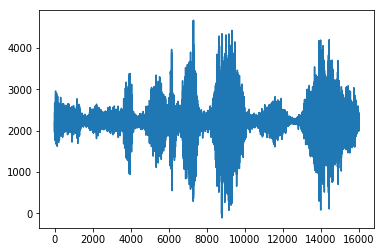

In [13]:
mic_pst_array = sess.get_perievent_stream_frames('microphone_0')
mic_pst_array.shape
plt.plot(np.nanmean(mic_pst_array, axis=0))

(14135, 122)

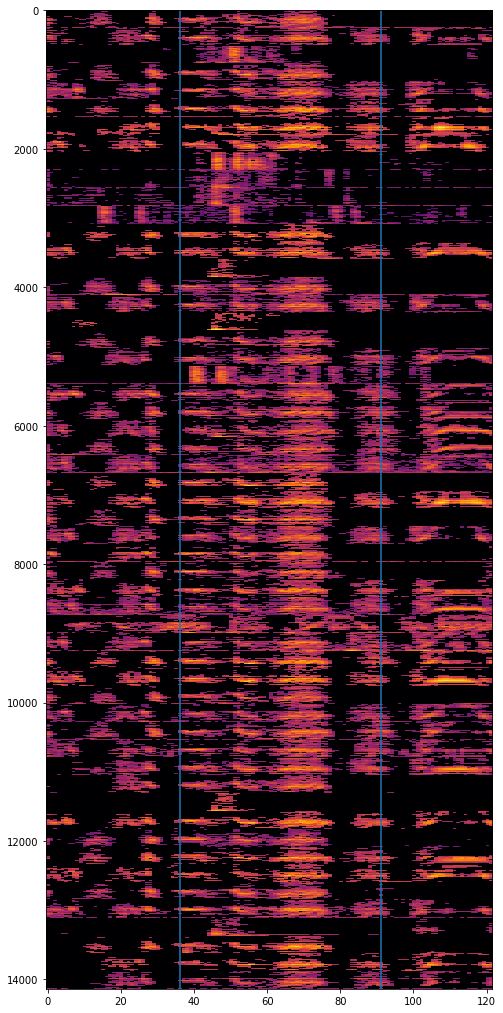

In [14]:
from scipy import signal as sg

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window=512, n_overlap=None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = int(n_window*0.75)
    if sigma is None:
        sigma = 1 / 200. * s_f

    # Make the spectrogram
    f, t, Sxx = sg.spectrogram(x, s_f, nperseg=n_window, noverlap=n_overlap, window=sg.gaussian(n_window, sigma),
                            scaling='spectrum')

    Sxx[[Sxx < np.max((Sxx) * 0.000055)]] = 1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms / 1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms / 1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    # Sxx = np.hstack((span_before, (Sxx), span_after))

    #if ax is None:
        #spec_fig, ax = plt.subplots()
        #ax = spec_fig.add_axes([0, 0, 1, 1])

    #ax.pcolormesh(((t - 0.5 * n_window / s_f) * 1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    #ax.set_xlim(-before_ms, after_ms + int(x.size / s_f * 1000.))
    #ax.set_ylim(0, 10000)
    #ax.imshow(np.log(Sxx[::-1]), aspect='auto', cmap='inferno', rasterized=True)
    # ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    return Sxx

sxx = plot_spectrogram(mic_pst_array[:, :, 0], 0, 0, 20000);
sxx.shape

many_spec = [plot_spectrogram(mic_pst_array[i, :, 0], 0, 0, 20000) for i in np.arange(mic_pst_array.shape[0])];
spec_arr = np.vstack(many_spec)
fig, ax = plt.subplots(figsize=(8, 18))
mark = viz_par['pre_samples']/viz_par['span'] * spec_arr.shape[1] * (-1)

ax.imshow(np.log(spec_arr[::-1]), aspect='auto', cmap='inferno')

ax.axvline(x=mark+15)
ax.axvline(x=mark-40)
spec_arr.shape

In [15]:
spec_arr.shape

(14135, 122)

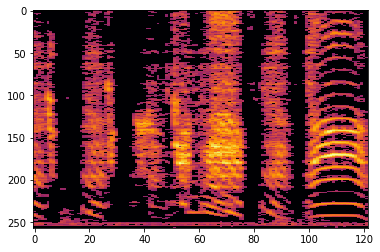

In [16]:
plt.imshow(np.log(many_spec[25][::-1]), aspect='auto', cmap='inferno')

## View units

In [17]:
sess.exp_struct

{'folders': {'raw': '/mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01',
  'kwik': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01',
  'msort': '/mnt/scratch/experiment/p14r14/Ephys/msort/2019-02-14_2250_01'},
 'files': {'par': '/mnt/scratch/experiment/p14r14/Ephys/msort/2019-02-14_2250_01/params.json',
  'set': '/mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01/settings.isf',
  'rig': '/mnt/zuperfinch/microdrive/birds/p14r14/Ephys/raw/2019-02-14_2250_01/rig.json',
  'kwd': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01/streams.kwd',
  'kwik': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01/sort_1/spikes.kwik',
  'kwe': '/data/experiment/microdrive/p14r14/Ephys/kwik/2019-02-14_2250_01/events.kwe',
  'mda_raw': '/mnt/scratch/experiment/p14r14/Ephys/msort/2019-02-14_2250_01/raw.mda'}}

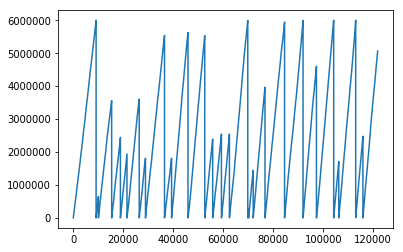

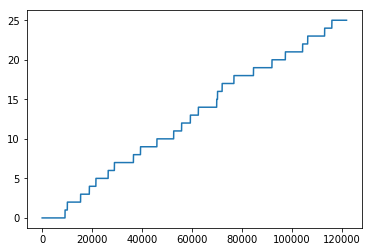

In [18]:
from pipefinch.h5tools.kwik import kwikfunctions as kwkf
from pipefinch.neural import units
reload(units)
reload(et)
all_clu = kwkf.list_units(sess.kwik_path)

i_unit = 24

current_clu = all_clu[i_unit]
a_unit = units.Unit(i_unit, sess.kwik_path, sess.kwd_path, port=sess.probe_port)
t, r = a_unit.get_time_stamps()

reload(kwkf)
kwkf.list_units(sess.kwik_path)['clu']
plt.plot(t)
plt.figure()
plt.plot(r)

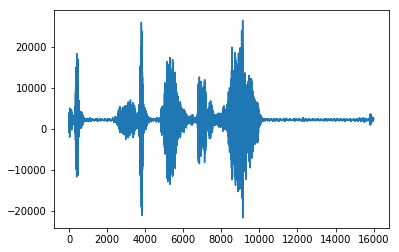

In [19]:
mic_stream = sess.get_mic_stream()[24]
plt.plot(mic_stream)

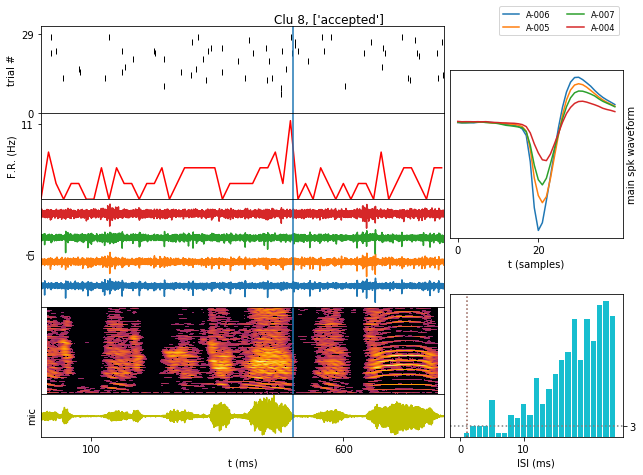

In [36]:
from pipefinch.neural import basic_plot as bp
reload(bp)
reload(session)
from pipefinch.util import spectral

fig = session.plot_unit(sess, 8, example_event_id=25);

In [21]:
from pipefinch.neural import units as un

In [22]:

a_unit = un.Unit(8, sess.kwik_path, sess.kwd_path)
isi_dist = a_unit.get_isi_dist()

In [23]:
np.sum(isi_dist[1])*.05

10.0

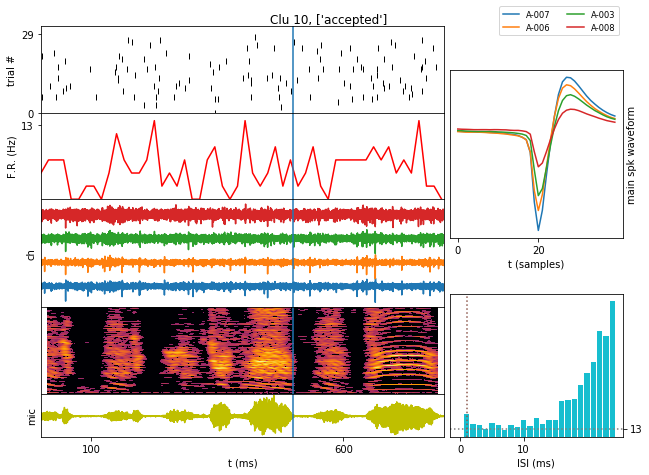

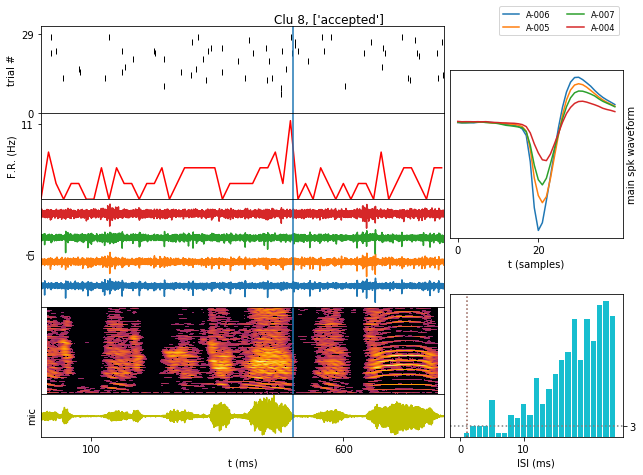

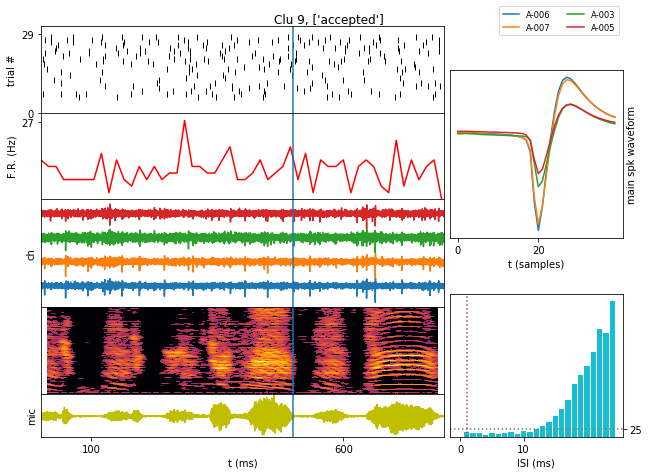

In [37]:
reload(session)
session.plot_all_units(sess, only_tags = ['accepted'], example_event_idx=25)

/home/zeke/anaconda3/envs/mountain/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


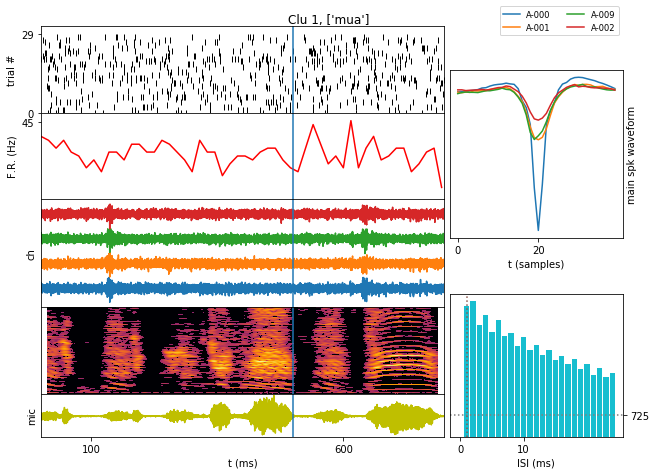

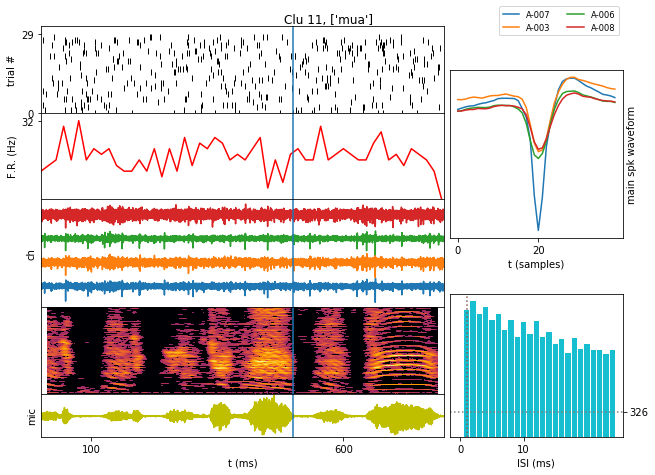

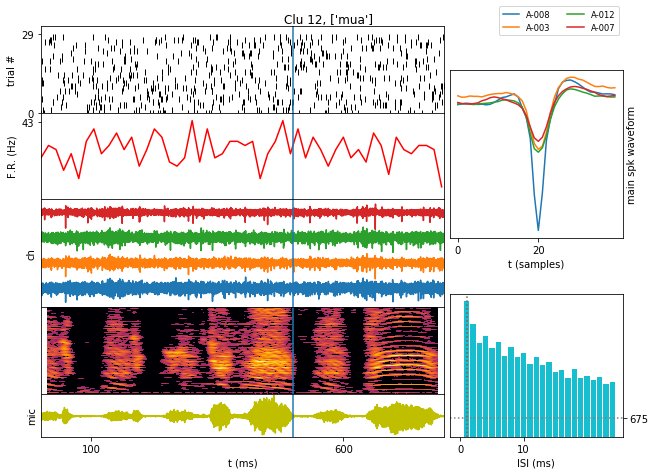

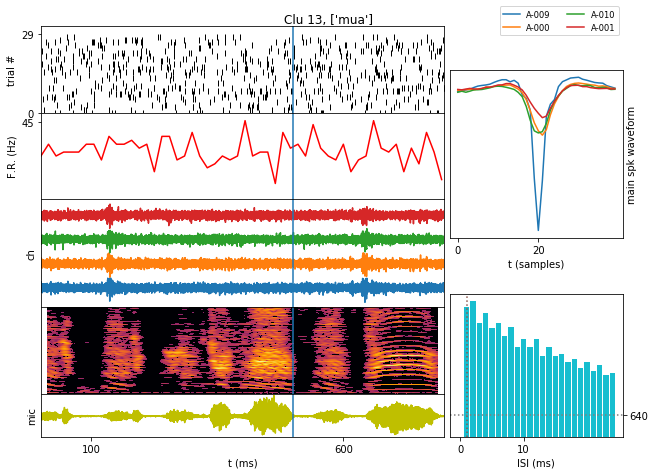

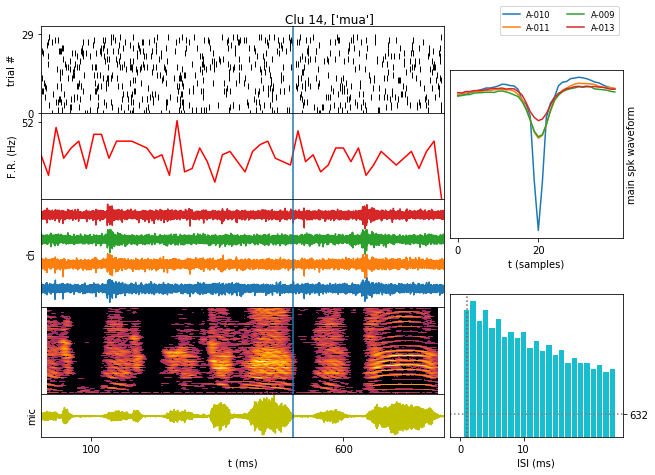

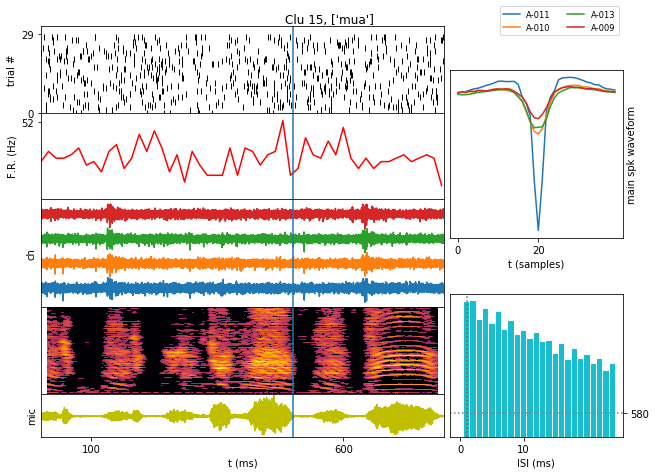

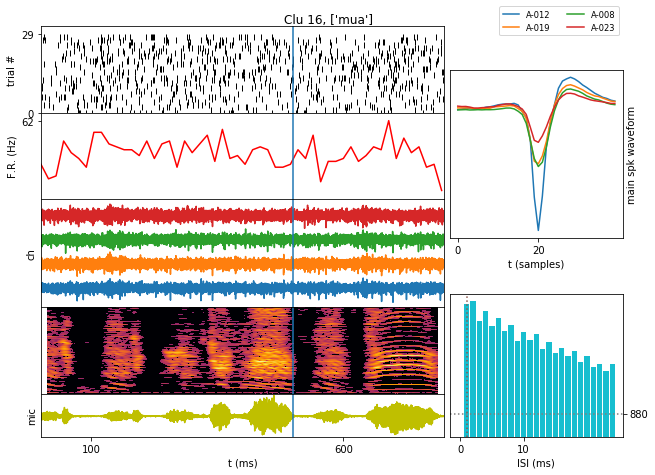

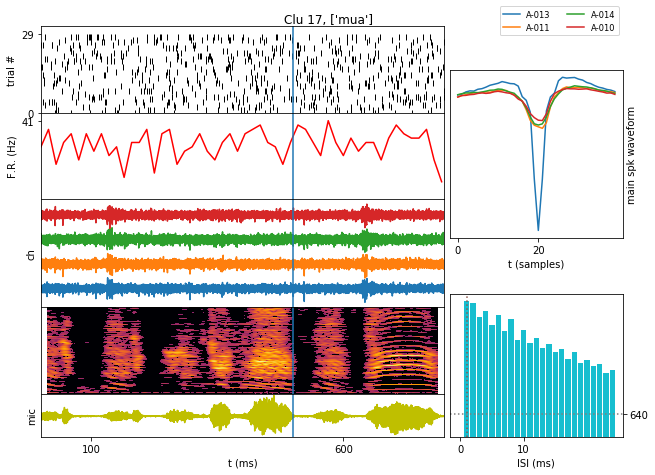

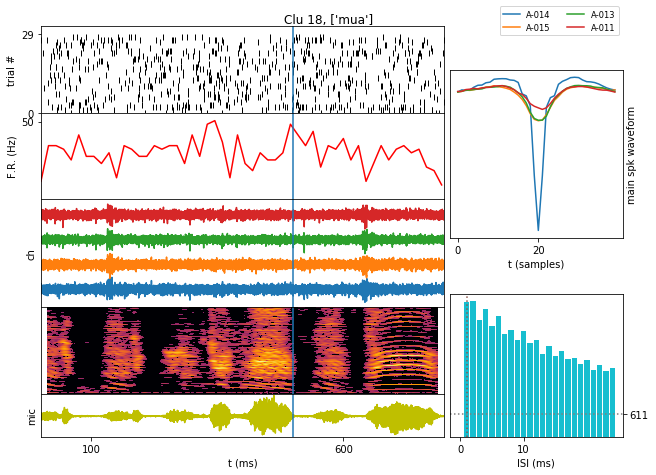

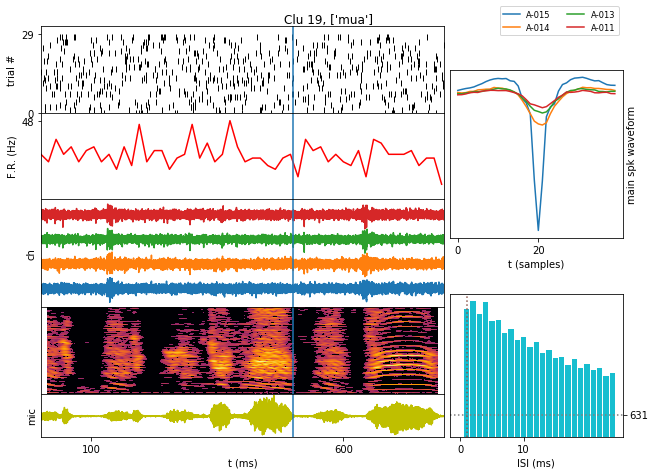

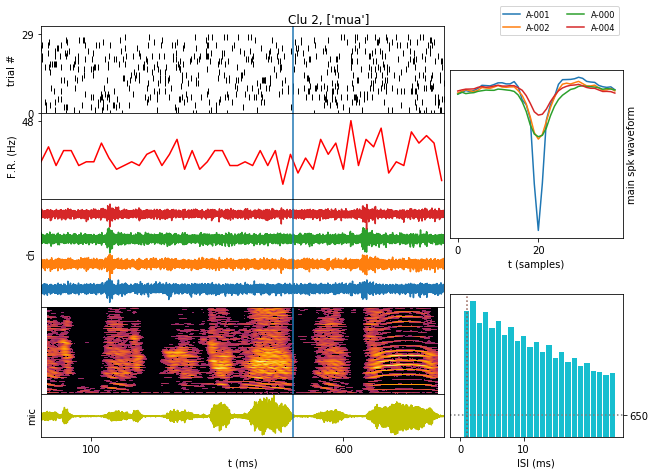

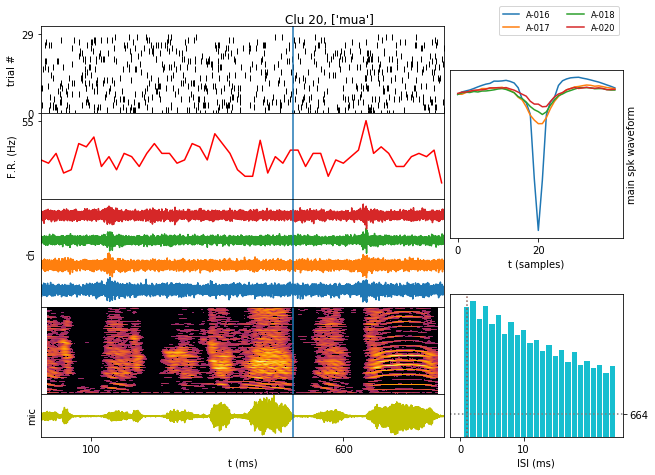

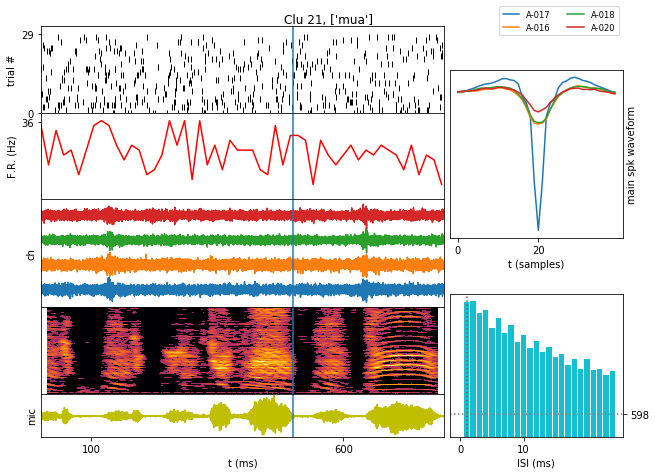

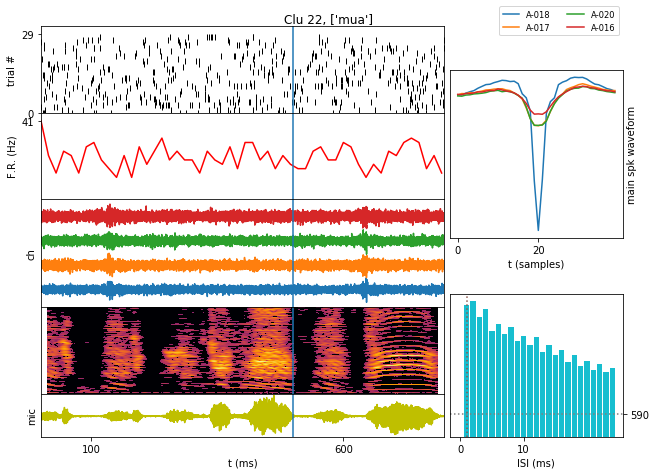

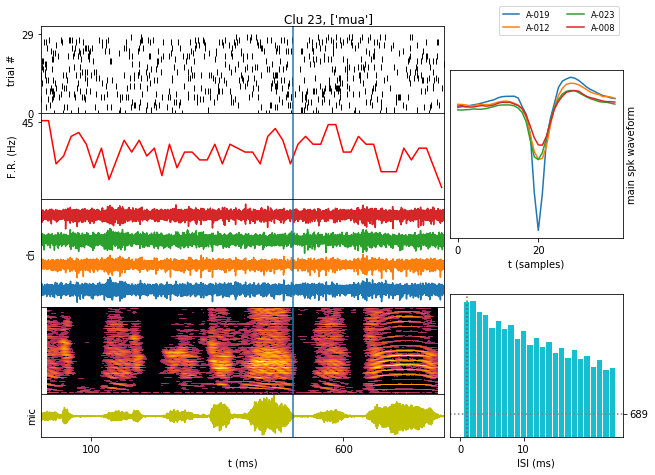

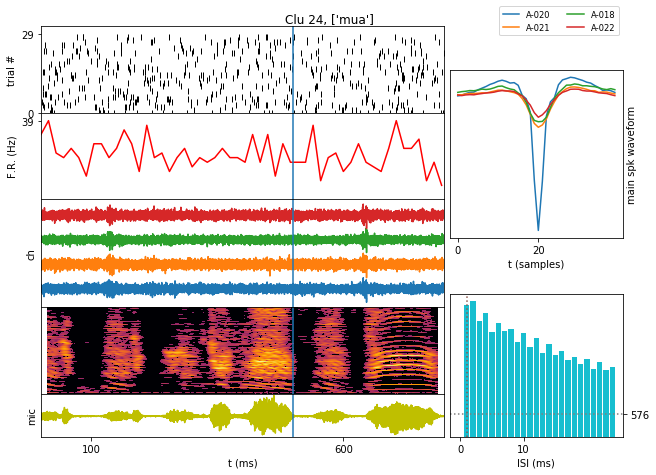

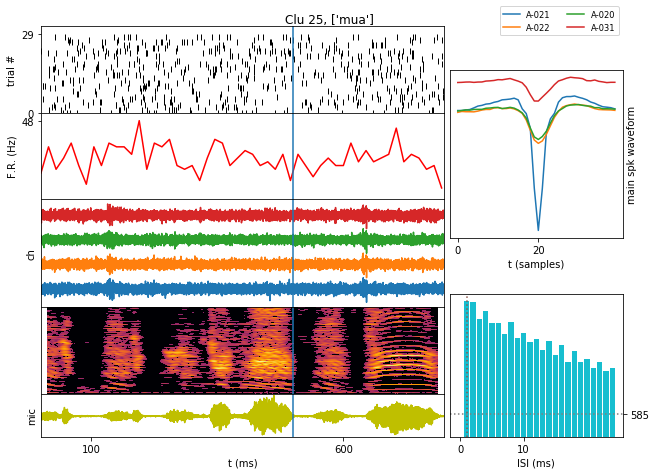

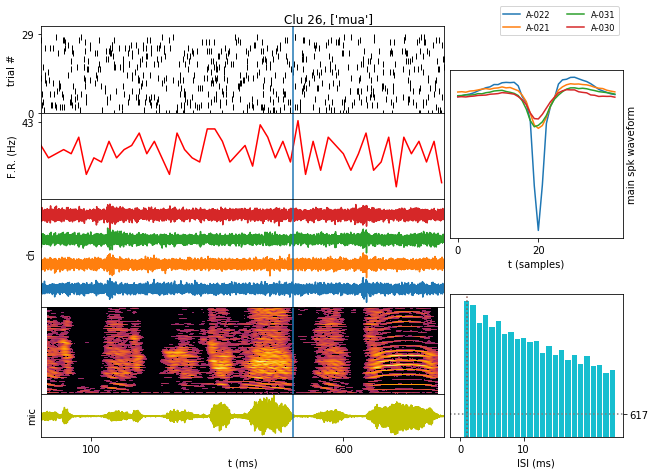

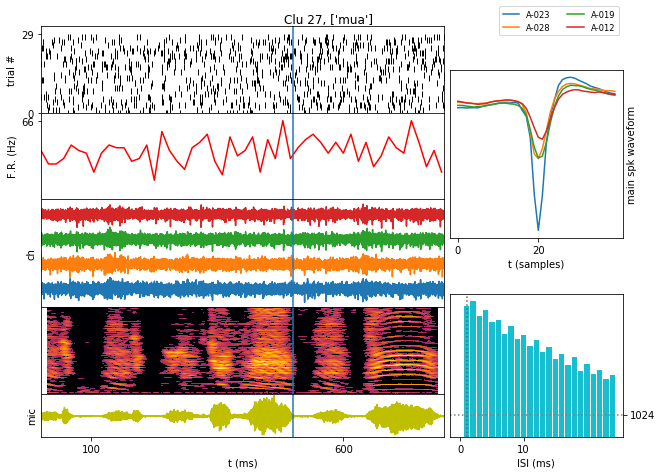

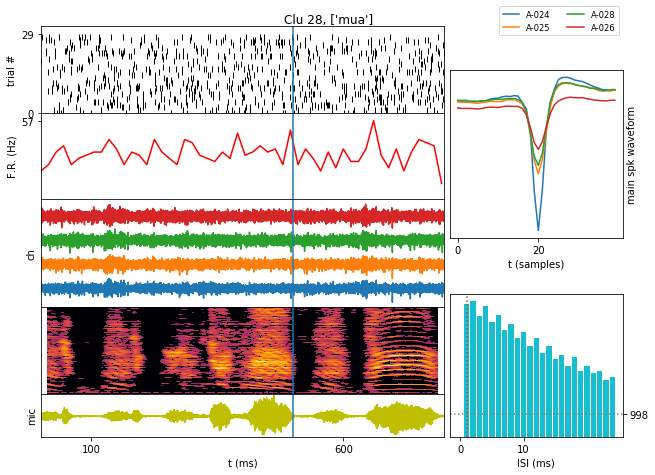

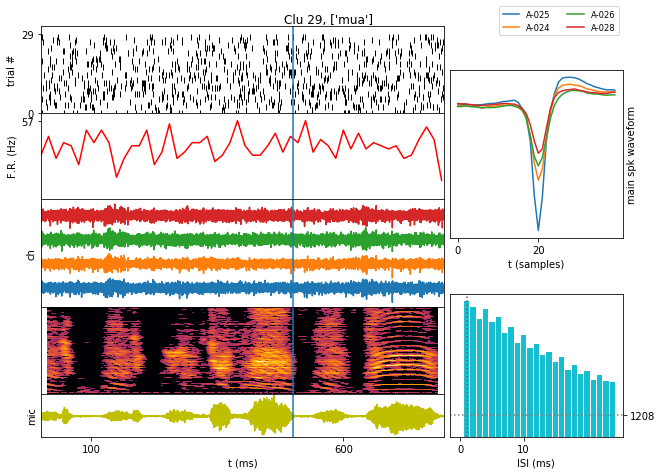

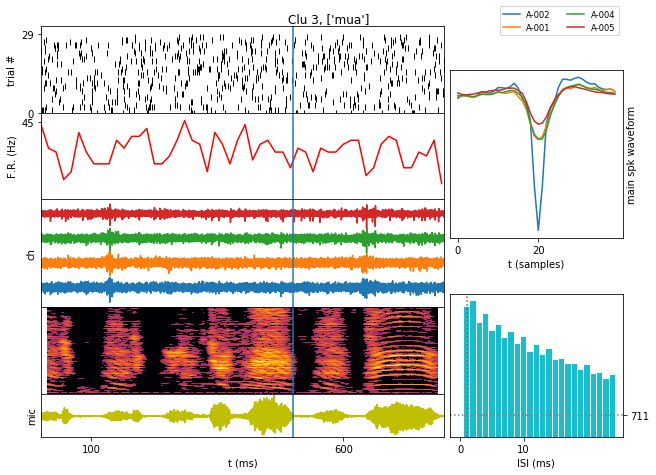

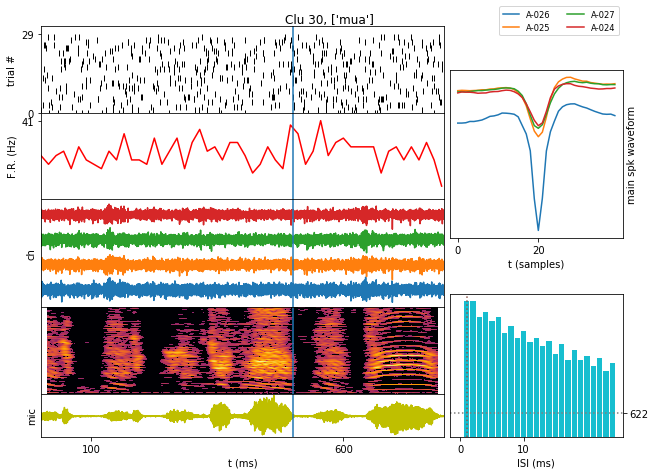

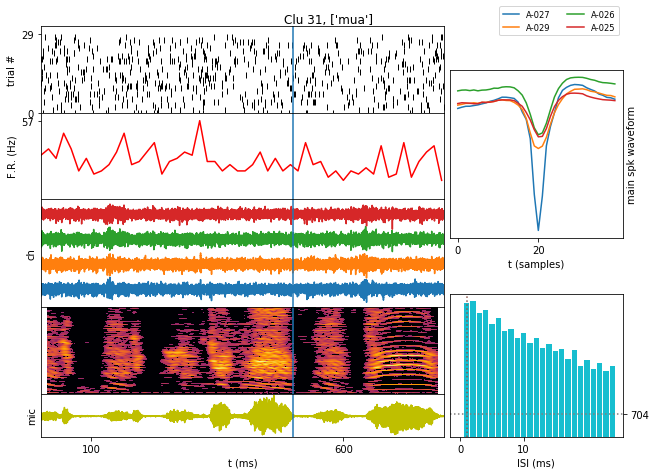

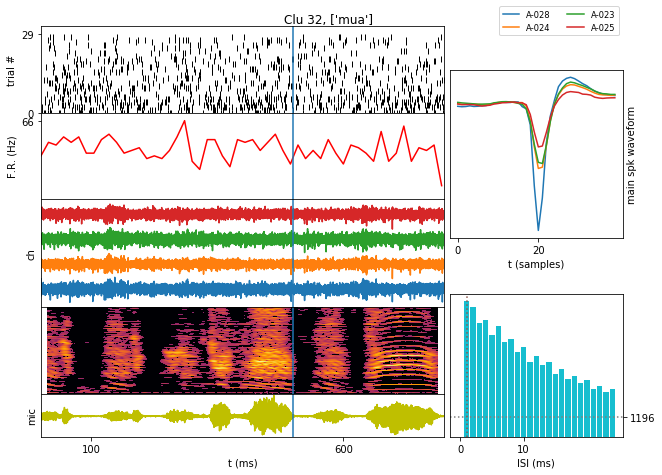

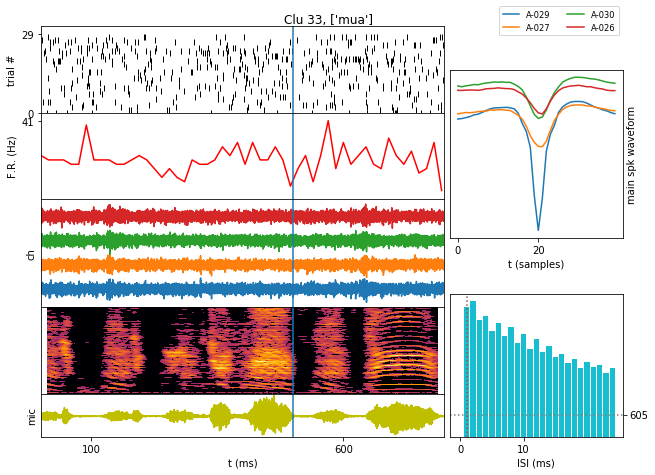

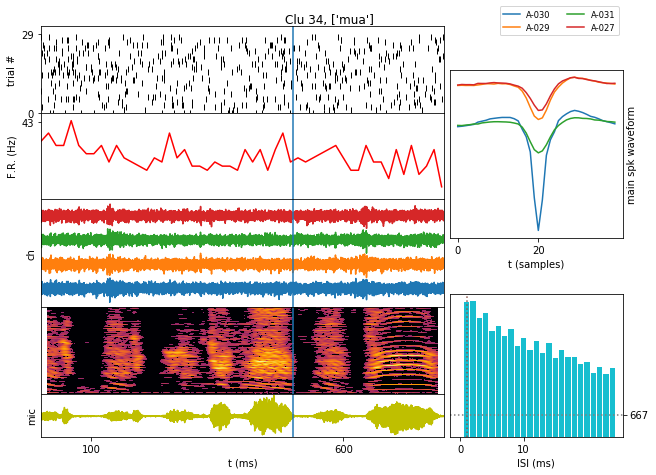

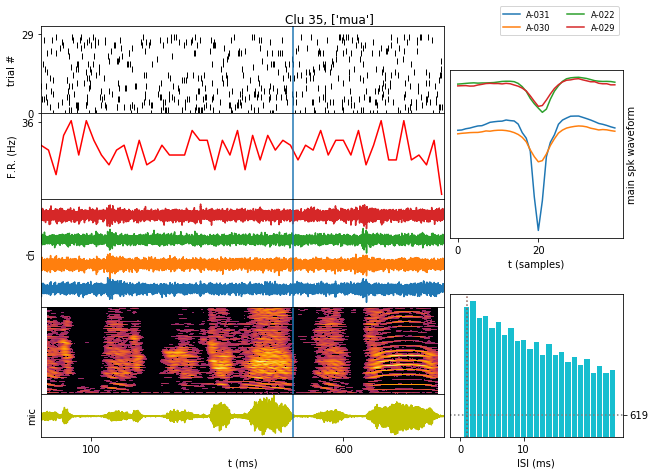

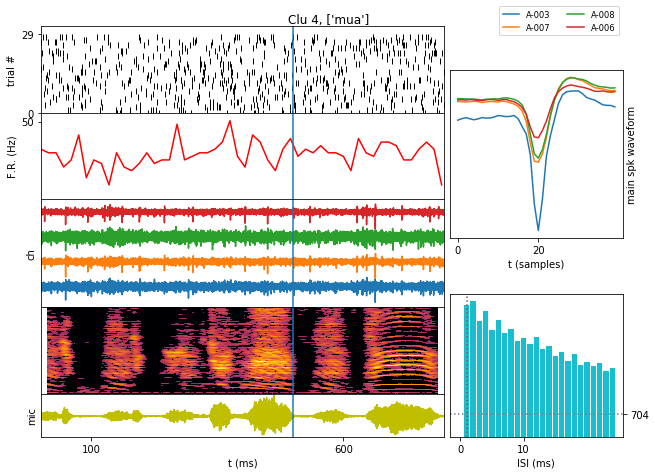

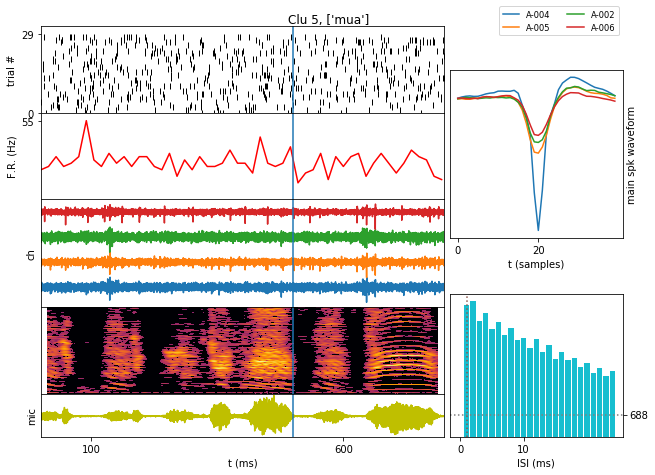

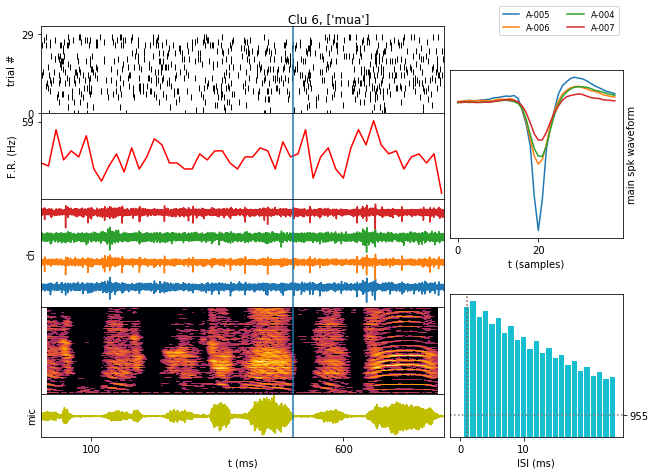

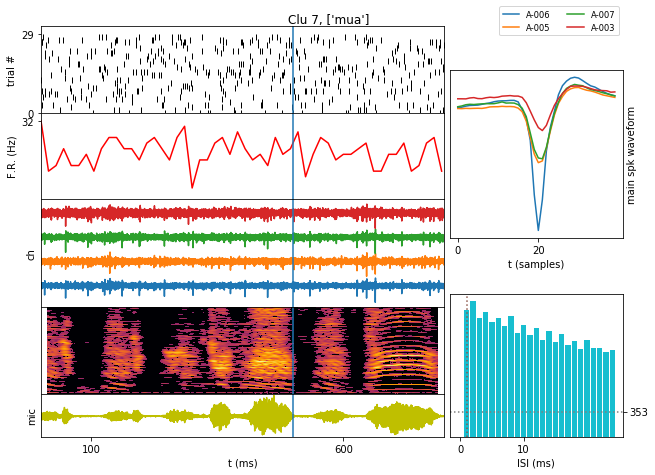

In [38]:
session.plot_all_units(sess, only_tags = ['mua'], example_event_idx=25)

In [48]:
reload(session)

<module 'pipefinch.neural.postsort.session' from '/home/zeke/repos/pipefinch/pipefinch/neural/postsort/session.py'>

In [43]:
a_unit = units.Unit(8, sess.kwik_path, sess.kwd_path, port=sess.probe_port)
a_unit.get_time_stamps()
a_unit.get_attrs()
a_unit.get_unit_chan_names()
a_unit.get_unit_main_chans_names()

array(['A-006', 'A-005', 'A-007', 'A-004'], dtype='<U6')

In [45]:
a_unit.get_attrs()

{'bursting_parent': 0,
 'cluster_group': 2,
 'dur_sec': 4764.49675,
 'firing_rate': 2.149230136425216,
 'isolation': 0.9988249118683902,
 'noise_overlap': 0.009694477085781417,
 'num_events': 10240,
 'overlap_cluster': 16,
 'peak_amp': 5.640303134918213,
 'peak_noise': 1.29463529586792,
 'peak_snr': 4.3566733835546865,
 't1_sec': 9.5908,
 't2_sec': 4774.08755,
 'tags': array(['accepted'], dtype='<U8')}

# DEBUG VIEWING UNITS

In [21]:
from pipefinch.neural import units
reload(kwdf)
reload(units)

a_unit = units.Unit(54, sess.kwik_path, sess.kwd_path)
t, r = a_unit.get_time_stamps()
a_unit.get_unit_spikes()

plt.plot(t)
plt.figure()
plt.plot(r)

KeyError: "Unable to open object (object '54' doesn't exist)"

In [39]:
units.Unit(7, sess.kwik_path, sess.kwd_path).get_unit_spikes()

KeyboardInterrupt: 

In [ ]:
reload(kwdf)

spk_arr = kwdf.collect_frames_fast(sess.kwd_path, r,  t-20,40, np.arange(32))

In [ ]:
spk_arr.shape

In [ ]:
sample = np.empty(0)
try:
    assert sample.size > 0, "no valid events"
except AssertionError as err:
    print(err.args)


In [ ]:
# get all unit waveforms in parallel
reload(units)
units.get_all_unit_waveforms(sess.kwik_path, sess.kwd_path)

In [ ]:
import h5py
kwkfile = h5py.File(sess.kwik_path, 'r')

r_path = "/channel_groups/0/spikes/recording"
clu_path = "/channel_groups/0/spikes/clusters/main"
t_path = '/channel_groups/0/spikes/time_samples'

recs = kwkfile[r_path][:]
clu = kwkfile[clu_path][:]
times = kwkfile[t_path][:]

In [ ]:
kwkfile.close()

In [ ]:
np.unique(recs)

In [ ]:
kwkfile['/channel_groups/0/spikes/clusters/main'][:]

In [ ]:
probe = {}
probe['a1x32-edge-5mm-20-177_H32'] = {i+1: (0, i*20) for i in range(32)}


# port_site maps
# each port is a dict {port: site}, where port is an int, site is an int
# port is

headstage = {}
headstage['intan-32-nn32'] = {23: 15, 22: 6, 21: 5, 20: 4, 19: 16, 18: 3, 17: 2, 16: 1,
                            15: 32, 14: 31, 13: 30, 12: 17, 11: 29, 10: 28, 9: 27, 8: 18,
                            24: 13, 25: 12, 26: 11, 27: 10, 28: 14, 29: 9, 30: 8, 31: 7,
                            0: 26, 1: 25, 2: 24, 3: 19, 4: 23, 5: 22, 6: 21, 7: 20}

def make_map(a_probe: dict, a_headstage: dict):
    # want to retrieve what coordinates are in each port of the headstage
    # headstage is {port: site}, probe is {site: coords}
    port_coords = {port: np.array(a_probe[site]) for port, site in sorted(a_headstage.items())}
    return (list(port_coords.values()))
    
np.vstack(make_map(probe['a1x32-edge-5mm-20-177_H32'], headstage['intan-32-nn32']))

In [ ]:
def site_port_map(probe_name: str, headstage_name: str):
    a_probe = probe[probe_name]
    a_headstage = headstage[headstage_name]

    return [h_port for site in a_probe.keys() for h_port, h_site in a_headstage.items() if h_site==site]

site_port_map('a1x32-edge-5mm-20-177_H32', 'intan-32-nn32')

In [23]:
import os